# Integration into KPIC2 to implement the whole process of metabolomics processing

## Install the DeepPIC package

In [1]:
!pip install rpy2
!pip install pyopls
!pip install pandas
!pip install numpy
!pip install scikit_learn
!pip install wget
!pip install matplotlib

  Using cached rpy2-3.5.4-py3-none-any.whl
  Using cached pyopls-20.3.post1-py3-none-any.whl
  Using cached wget-3.2-py3-none-any.whl
  Using cached matplotlib-3.5.3-cp38-cp38-win_amd64.whl (7.2 MB)


## Load the required packages

In [2]:
import rpy2.robjects as robjects
from rpy2.robjects import numpy2ri
from pyopls import OPLS
import pandas as pd
import numpy as np
from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict, LeaveOneOut, KFold 
from sklearn.metrics import r2_score
from KPIC2.permutation_vip import *
import warnings
import wget
from zipfile import ZipFile
import matplotlib.pyplot as plt
plt.rc('font',family='Calibri')

## Download the metabolomics dataset

In [3]:
url = "https://github.com/yuxuanliao/DeepPIC/releases/download/v1.0.0/Metabolomics.dataset.zip"
save_path = wget.download(url, ".")
with ZipFile(save_path, 'r') as zip:
    zip.extractall(path = ".")
save_path_unzip = save_path[:-4]
path_unzip = save_path_unzip[2:]
path_unzip = path_unzip.replace('.', ' ')
pics5_path1 = path_unzip + "/1.mzXML"
pics4_path2 = path_unzip + "/2.mzXML"
pics_1_fp = path_unzip + "/"

100% [......................................................................] 463974197 / 463974197

## Load RTs read from each LC-MS file in the metabolomics dataset

In [4]:
pics5_ps = 'KPIC2/files/scantime/scantime01/rt1.txt'
pics4_ps = 'KPIC2/files/scantime/scantime02/rt2.txt'
pics_1_fps = 'KPIC2/files/scantime'

## Load PICs extracted by DeepPIC from the metabolomics dataset. By running extract.py, you can use DeepPIC to extract PICs. Please refer to extract.ipynb for details.

In [5]:
pics5_ffn = 'KPIC2/files/pics/pics01'
pics5_dir = pics5_ffn + '/'
pics4_ffn = 'KPIC2/files/pics/pics02'
pics4_dir = pics4_ffn + '/'
pics_1_ff = 'KPIC2/files/pics'

## Import the functions in KPIC2

In [6]:
numpy2ri.activate()
robjects.r('''source('KPIC2/KPIC2.R')''')
kpic_DeepPIC = robjects.globalenv['kpic_DeepPIC']
PICset_decpeaks = robjects.globalenv['PICset_decpeaks']
PICset_split = robjects.globalenv['PICset_split']
PICset_getPeaks = robjects.globalenv['PICset_getPeaks']
PICset_group = robjects.globalenv['PICset_group']
PICset_align1 = robjects.globalenv['PICset_align1']
PICset_align2 = robjects.globalenv['PICset_align2']
PICset_align3 = robjects.globalenv['PICset_align3']
kpic_iso = robjects.globalenv['kpic_iso']
kpic_mat = robjects.globalenv['kpic_mat']
kpic_fill = robjects.globalenv['kpic_fill']
kpic_pattern = robjects.globalenv['kpic_pattern']

In [7]:
pics_1 = kpic_DeepPIC(pics5_ffn, pics5_dir, pics5_path1, pics5_ps, pics4_ffn, pics4_dir, pics4_path2, pics4_ps, pics_1_ff, pics_1_fps, pics_1_fp)
PICS = PICset_decpeaks(pics_1)
PICS = PICset_split(PICS)
PICS = PICset_getPeaks(PICS)
groups_raw = PICset_group(PICS)
groups_align1 = PICset_align1(groups_raw)
groups_align2 = PICset_align2(groups_align1)
groups_align3 = PICset_align3(groups_align2)
groups_align = kpic_iso(groups_align3)
data = kpic_mat(groups_align)
data = kpic_fill(data)
result = kpic_pattern(data, file_save_path = "./KPIC2/files/KPIC2_result.csv")

filling peaks of Metabolomics dataset/1.mzXML 
filling peaks of Metabolomics dataset/2.mzXML 
filling peaks of Metabolomics dataset/3.mzXML 
filling peaks of Metabolomics dataset/4.mzXML 
filling peaks of Metabolomics dataset/5.mzXML 
filling peaks of Metabolomics dataset/6.mzXML 
filling peaks of Metabolomics dataset/7.mzXML 
filling peaks of Metabolomics dataset/8.mzXML 
filling peaks of Metabolomics dataset/9.mzXML 
filling peaks of Metabolomics dataset/10.mzXML 
filling peaks of Metabolomics dataset/11.mzXML 
filling peaks of Metabolomics dataset/12.mzXML 
filling peaks of Metabolomics dataset/13.mzXML 
filling peaks of Metabolomics dataset/14.mzXML 
filling peaks of Metabolomics dataset/15.mzXML 
filling peaks of Metabolomics dataset/16.mzXML 
filling peaks of Metabolomics dataset/17.mzXML 
filling peaks of Metabolomics dataset/18.mzXML 
filling peaks of Metabolomics dataset/19.mzXML 
filling peaks of Metabolomics dataset/20.mzXML 


## Convert the file format for the OPLS-DA scores plot, permutation test, and biomarkers selection

In [8]:
data = Datatransform(file_csv_path = "./KPIC2/files/KPIC2_result.csv",plot_csv_format = "./KPIC2/files/KPIC2_result_plot.csv")

## OPLS-DA

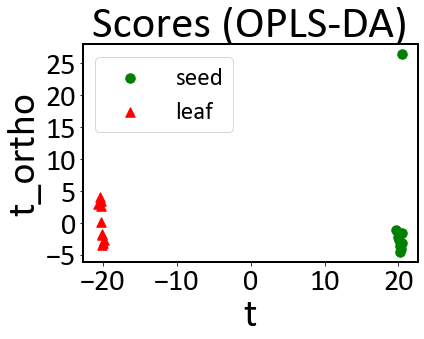

In [9]:
X = np.array(data.values[:,1:].T,dtype=float)
Y= np.array([0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1])
opls = OPLS(1)
Z = opls.fit_transform(X, Y)
pls = PLSRegression(1)
uncorrected_r2 = r2_score(Y, pls.fit(X, Y).predict(X))
corrected_r2 = r2_score(Y, pls.fit(Z, Y).predict(Z))
uncorrected_q2 = r2_score(Y, cross_val_predict(pls, X, Y, cv=LeaveOneOut()))
corrected_q2 = r2_score(Y, cross_val_predict(pls, Z, Y, cv=LeaveOneOut()))
pls.fit_transform(Z, Y)
fig = plt.figure()
ax = fig.add_subplot(111)
bwith = 2
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
df = pd.DataFrame(np.column_stack([pls.x_scores_, opls.T_ortho_[:, 0]]),index=Y,columns=['t', 't_ortho'])                           
pos_df = df[Y==0]
neg_df = df[Y==1]
plt.scatter(neg_df['t'], neg_df['t_ortho'], s=90, c='g', marker='o', label='seed')
plt.scatter(pos_df['t'], pos_df['t_ortho'], s=90, c='red',marker='^', label='leaf')
ax.set_title('Scores (OPLS-DA)',fontproperties = 'Calibri', size = 45)
ax.set_xlabel('t',font)
ax.set_ylabel("t_ortho",font)    
plt.yticks(fontproperties = 'Calibri', size = 30)
plt.xticks(fontproperties = 'Calibri', size = 30)
plt.legend(loc = 'upper left', prop={'family' : 'Calibri', 'size' : 25})

## Permutation test 

(array([-2. , -1.5, -1. , -0.5,  0. ,  0.5,  1. ,  1.5]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

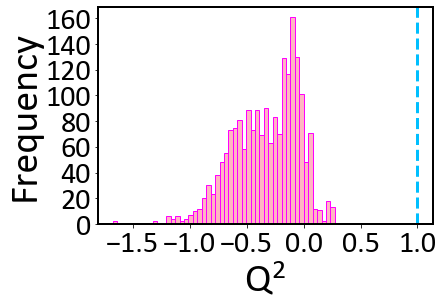

In [10]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    kf = KFold(n_splits = 5, shuffle=True, random_state=420) 
    permutation_scores = permutation_test_score(pls, Z, Y, groups= None , cv=kf,
                                n_permutations=2000, n_jobs=1, random_state=420,
                                verbose=0, fit_params=None)
fig = plt.figure()
ax2 = fig.add_subplot(111)
bwith = 2 
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
ax2.hist(permutation_scores[0][1], bins=50, density=False, fc="lightpink", ec="magenta")
ax2.axvline(permutation_scores[0][0], linewidth = 3, ls="--", color="deepskyblue")
ax2.set_xlabel('$\mathregular{Q^2}$',font)
ax2.set_ylabel("Frequency",font)    
plt.yticks(fontproperties = 'Calibri', size = 30)
plt.xticks(fontproperties = 'Calibri', size = 30)

## Biomarkers selection

(array([1.186, 1.187, 1.188, 1.189, 1.19 , 1.191, 1.192]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

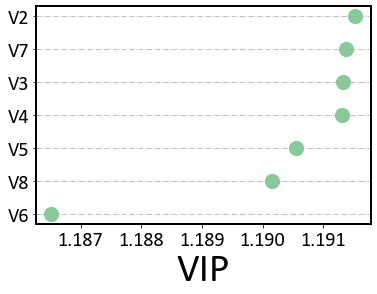

In [11]:
X = np.array(data.values[:,1:].T,dtype=float)
COMs = data.values[:,0]
VIPs = vip(Z, Y, pls)   
COM = []
VIP = []
for vv in range(11):
    if VIPs[vv]>=1:
        VIP.append(VIPs[vv])
        COM.append(COMs[vv])
sorted_vips = sorted(enumerate(VIP), key=lambda x: x[1])
idx = [i[0] for i in sorted_vips]
vips = [i[1] for i in sorted_vips]
COMS=[]
for jj in range(len(COM)):
    COMS.append(COM[idx[jj]])
fig = plt.figure()
ax11 = fig.add_subplot(111)
bwith = 2
TK = plt.gca()
TK.spines['bottom'].set_linewidth(bwith)
TK.spines['left'].set_linewidth(bwith)
TK.spines['top'].set_linewidth(bwith)
TK.spines['right'].set_linewidth(bwith)
font = {'family' : 'Calibri',
'weight' : 'normal',
'size'   : 40,
    }
plt.grid(axis="y",linestyle='-.')
plt.scatter(vips,range(len(COMS)),c="#88c999",s=200,marker="o")
ax11.set_xlabel('VIP',font)
plt.yticks(range(len(COMS)),COMS,fontproperties = 'Calibri', size = 20)
plt.xticks(fontproperties = 'Calibri', size = 20)